<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

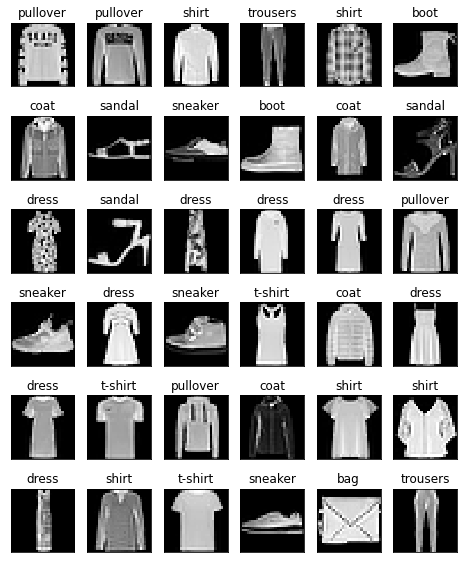

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [3]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [4]:
print(train_images.shape)
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))
print(train_2D.shape)

(60000, 28, 28)
(60000, 784)


In [5]:
print(train_labels.shape)
print(train_labels.shape[0])

(60000,)
60000


In [6]:
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

In [7]:
print(train_half.shape)
print(train_labels_half.shape)

(30000, 784)
(30000, 1)


From HW1

In [8]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [59]:
# this is the size of our encoded representations (reduced dimensionality)
encoding_dim = 32  

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
print(train_half.shape)
print(train_labels_half.shape)

(30000, 784)
(30000, 1)


In [63]:
# My code here
x_train = train_half[0:int(train_half.shape[0]*0.8), :]
x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

x_train = x_train / np.amax(train_half)
x_test = x_test / np.amax(train_half)

print(x_train.shape)
print(x_test.shape)

(24000, 784)
(6000, 784)


In [64]:
hw1history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 1s 47us/sample - loss: 0.4946 - acc: 0.4602 - val_loss: 0.3984 - val_acc: 0.4943
Epoch 2/50
24000/24000 [==============================] - 1s 39us/sample - loss: 0.3746 - acc: 0.4959 - val_loss: 0.3577 - val_acc: 0.4993
Epoch 3/50
24000/24000 [==============================] - 1s 39us/sample - loss: 0.3458 - acc: 0.5010 - val_loss: 0.3375 - val_acc: 0.5037
Epoch 4/50
24000/24000 [==============================] - 1s 38us/sample - loss: 0.3303 - acc: 0.5040 - val_loss: 0.3253 - val_acc: 0.5055
Epoch 5/50
24000/24000 [==============================] - 1s 39us/sample - loss: 0.3209 - acc: 0.5055 - val_loss: 0.3191 - val_acc: 0.5061
Epoch 6/50
24000/24000 [==============================] - 1s 43us/sample - loss: 0.3148 - acc: 0.5064 - val_loss: 0.3133 - val_acc: 0.5073
Epoch 7/50
24000/24000 [==============================] - 1s 39us/sample - loss: 0.3103 - acc: 0.5070 - val_loss: 0.3

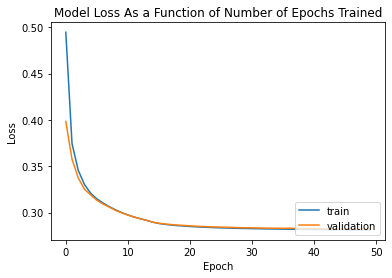

In [65]:
plot_model_loss(hw1history)

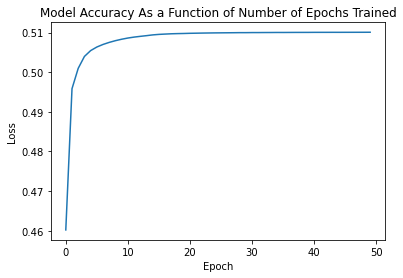

In [68]:
plot_model_accuracy(hw1history)

## HACKERMAN

In [9]:
# this is the size of our encoded representations (reduced dimensionality)
encoding_dim = 32  

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='linear')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# compile model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

print(train_half.shape)
print(train_labels_half.shape)

# My code here
x_train = train_half[0:int(train_half.shape[0]*0.8), :]
x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

x_train = x_train / np.amax(train_half)
x_test = x_test / np.amax(train_half)

print(x_train.shape)
print(x_test.shape)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(30000, 784)
(30000, 1)
(24000, 784)
(6000, 784)


In [10]:
hw1history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 1s 33us/sample - loss: 0.0735 - acc: 0.0027 - val_loss: 0.0382 - val_acc: 0.0045
Epoch 2/50
24000/24000 [==============================] - 1s 28us/sample - loss: 0.0321 - acc: 0.0072 - val_loss: 0.0280 - val_acc: 0.0095
Epoch 3/50
24000/24000 [==============================] - 1s 26us/sample - loss: 0.0261 - acc: 0.0104 - val_loss: 0.0245 - val_acc: 0.0125
Epoch 4/50
24000/24000 [==============================] - 1s 26us/sample - loss: 0.0233 - acc: 0.0123 - val_loss: 0.0221 - val_acc: 0.0135
Epoch 5/50
24000/24000 [==============================] - 1s 23us/sample - loss: 0.0212 - acc: 0.0133 - val_loss: 0.0204 - val_acc: 0.0148
Epoch 6/50
24000/24000 [==============================] - 1s 25us/sample - loss: 0.0197 - acc: 0.0146 - val_loss: 0.0192 - val_acc: 0.0178
Epoch 7/50
24000/24000 [==============================] - 1s 23us/sample - loss: 0.0187 - acc: 0.0163 - val_loss: 0.0

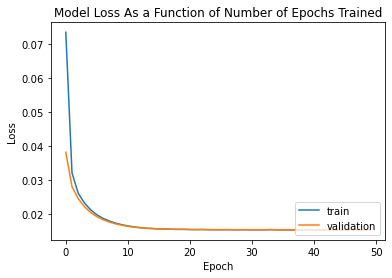

In [11]:
plot_model_loss(hw1history)

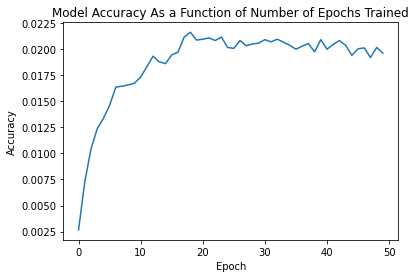

In [12]:
plot_model_accuracy(hw1history)

## Q2
> Use the remaining half of the original set as inputs to train a densely connected multilayer NN that learns, via backpropagation to classify the images.
1. Pick the proper activiation functions n the hidden units
2. Pick the proper activation function on the output units for a classificaiotn network
3. Make sure you also pick a proper loss function for a classification network

--> Multiclass classification: Relu, softmax, categorical_cross_entropy

In [ ]:
def create_network(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='sparse_categorical_crossentropy'):
    network = models.Sequential()
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            if node_list[-1] == 1 and len(func_list) == 1:
                print("BINARY CLASSIFICATION!")
                my_func = 'sigmoid'
                loss_func = 'binary_crossentropy'
            elif len(func_list) == 1:
                print("MULTICLASS CLASSIFICATION!")
                my_func = 'softmax'
                loss_func = 'categorical_crossentropy'
            else:
                print("CUSTOM CLASSIFICATION!")
                my_func = func_list[-1]
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [ ]:
def run_pipeline(train_array, train_labels, test_dim, test_pats=None, test_labels=None, num_epochs=30, my_batch=1):
    best_acc = -1
    best_val_acc = -1
    
    input_dim = train_array.shape[1]
    
    for _ in range(5):
        network = create_network(test_dim, input_dim)
        
        history = network.fit(train_array, 
                              train_labels, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        
        # Determine if this model was better than the previous ones
        new_acc = history.history['acc'][-1]
        new_val_acc = history.history['val_acc'][-1]
        if new_acc > best_acc and new_val_acc > best_val_acc:
            best_acc = new_acc
            best_val_acc = new_val_acc
            best_history = history
            best_network = network
        # Show the accuracy plot each time
        # plot_model_acc(history)

    # Show the accuracy of the best plot
    plot_model_acc(best_history)
    
    '''
    out = best_network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)
    
    results = best_network.evaluate(test_pats, 
                           test_labels_onehot_2D, 
                           verbose=False)

    test_loss = results[0]
    test_acc = results[1]

    print('test_loss (MSE)     : {}'.format(test_loss))
    print('test_acc (%Correct) : {}'.format(test_acc))
    '''
    
    return best_network, best_history #, out, results

In [ ]:
train_half2 = train_shuffled[train_shuffled.shape[0]//2:]
train_labels_half2 = train_labels_shuffled[train_shuffled.shape[0]//2:]

print(train_half2.shape)
print(train_labels_half2.shape)

# From the man himself:
> Instead of "fixing these weights" just use the weights and biases to calculate the activations, which will then be used as inputs to a trained network

In [ ]:
aaW = autonetwork.layer[0].get_weights()[0]
aab = autonetwork.layer[0].get_weights()[1]
backprop_network.layer[0].set_weights(W)

In [19]:
def apply_weights(aaW, aab, x):
    for ele in x:
        yield aaW*ele + aab

In [20]:
# y = mx + b
# fixed_inputs = W * original_inputs + b

# fixed_input = numpy.fromiter((<some_func>(x) for x in <something>),<dtype>,<size of something>)
fixed_input = numpy.fromiter(apply_weights(aaW, aab, x) for x in train_half2),float,train_half2.shape[0])

SyntaxError: invalid syntax (Temp/ipykernel_10044/1139922753.py, line 5)

In [21]:
me = apply_weights(aaW, aab, x)

NameError: name 'aaW' is not defined

In [22]:
next(me)

NameError: name 'me' is not defined

In [18]:
next(me)

NameError: name 'me' is not defined

In [ ]:
next(me)

In [24]:
network = models.Sequential()

network.add(layers.Dense(test_dim, 
                 activation='relu', 
                 input_shape=(input_dim,)))
network.add(layers.Dense(input_dim, 
                 activation='softmax', 
                 input_shape=(test_dim,)))

# configure optimizer
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
network.compile(optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['accuracy', 'mse'])

NameError: name 'autonetwork' is not defined

In [ ]:
network = models.Sequential()

network.add(layers.Dense(test_dim, 
                 activation='linear', 
                 input_shape=(input_dim,)))
network.add(layers.Dense(input_dim, 
                 activation='linear', 
                 input_shape=(test_dim,)))

# configure optimizer
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
network.compile(optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['accuracy', 'mse'])
    